<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_1brkpt_TESTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
%reset -f

### Imports

In [112]:
!pip install rioxarray --quiet
!pip install torchmetrics --quiet
!pip install permetrics --quiet

In [113]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 16, 17]])
#X = np.array([[1, 4, 7, 1], [2, 1, 8, 11], [3, 6, 1, 12]])
#mask = iso == 1
#X = np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
print(X)
print(X.transpose())
print(np.rot90(X))


[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 16 17]]
[[ 1  5  9 13]
 [ 2  6 10 14]
 [ 3  7 11 16]
 [ 4  8 12 17]]
[[ 4  8 12 17]
 [ 3  7 11 16]
 [ 2  6 10 14]
 [ 1  5  9 13]]


### Dunn Score/No Breakpoint

(1281, 2042)
Dunn Index: 0.30936544680035
Dunn Index: 0.3183041713110546
Dunn Index: 0.2361336670492331
Dunn Index: 0.2132001734813603
Dunn Index: 0.1615071840975124
Dunn Index: 0.16137535467613146
Dunn Index: 0.1665018720513637
Dunn Index: 0.13607616472649753
Dunn Index: 0.13953303205314635
Dunn Index: 0.15081720825730857
Dunn Index: 0.13303993424481653
Dunn Index: 0.1505874277771851
Dunn Index: 0.12054155250662574
Dunn Index: 0.15772419845973762
Dunn Index: 0.13991943459852338


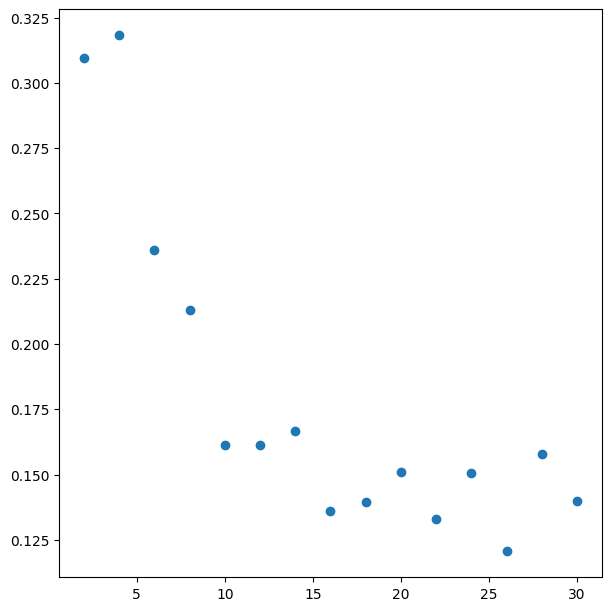

In [114]:
import matplotlib.pyplot as plt
import torch
from torchmetrics.clustering import DunnIndex
import numpy as np
import pandas as pd
import rioxarray as rx
import os

dunn_index = DunnIndex(p=2)


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc.tif'))
arr = com_im.values
shp = com_im.values.shape
new_arr = []
for i in range(shp[0]):
  filtered_arr = arr[i, :, :][mask]
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
X = torch.tensor(X.astype(float))

for n in test_cluster_sizes:

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  cluster_labels = torch.tensor(cluster_labels.astype(float))
  score = dunn_index(X, cluster_labels)
  test_scores.append(score)

  print(f"Dunn Index: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)

dunn_scores = test_scores


###Dunn Scores/One Breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-3305133069.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


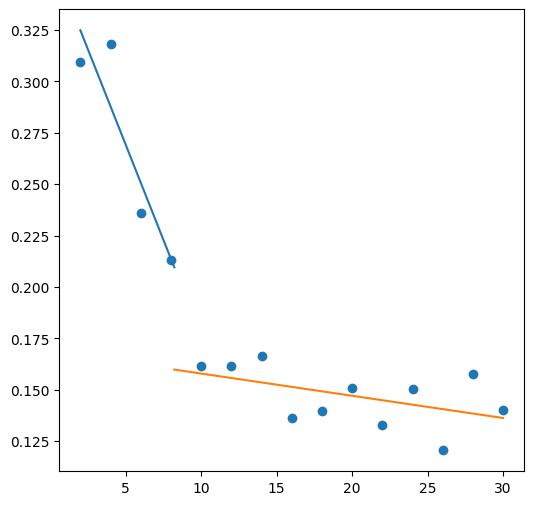

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Silhouette Score/No Breakpoint

Silhouette score: 0.239397976984679
Silhouette score: 0.23852574353427788
Silhouette score: 0.19851622695799778
Silhouette score: 0.2006121253601585
Silhouette score: 0.17547052351272993
Silhouette score: 0.1682303979192101
Silhouette score: 0.17162756542537805
Silhouette score: 0.1501002614655841
Silhouette score: 0.15435094356701234
Silhouette score: 0.1464409340256382
Silhouette score: 0.14260906425675654
Silhouette score: 0.143754768235252
Silhouette score: 0.1461846984695676
Silhouette score: 0.14681080947934047
Silhouette score: 0.1469336917080739


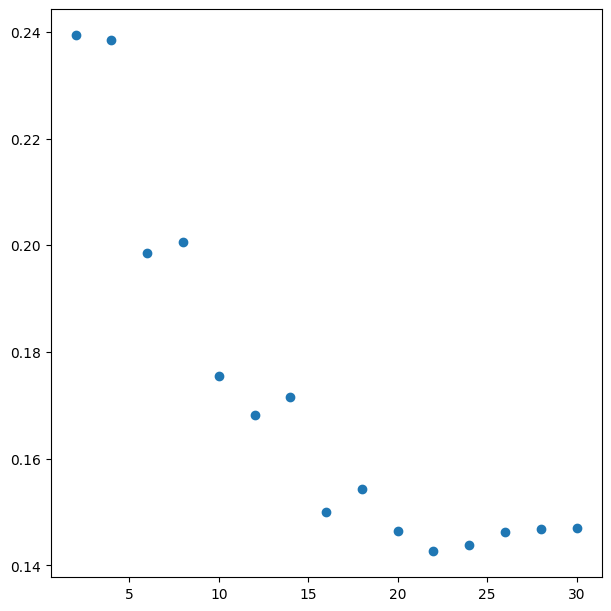

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os

isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)

com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc.tif'))
arr = com_im.values
shp = com_im.values.shape
new_arr = []
for i in range(shp[0]):
  filtered_arr = arr[i, :, :][mask]
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

  print(f"Silhouette score: {avg_score}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)

silhouette_scores = test_scores

###Silhouette Score/One Breakpoint

Optimal breakpoint 1: 14.222222222222221


/tmp/ipython-input-3164484002.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


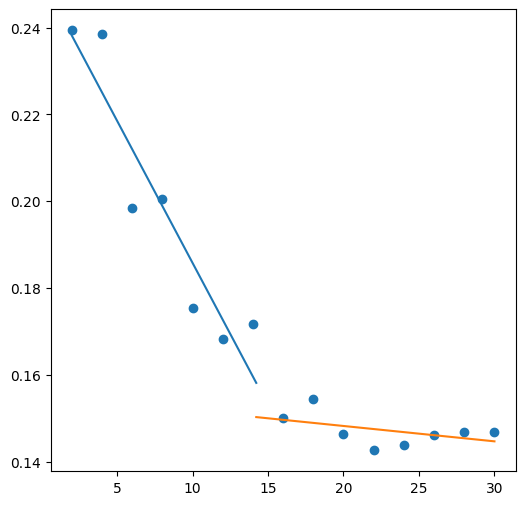

In [ ]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


### Within-cluster Sum of Squares

In [120]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import rioxarray as rx
import os


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)

com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc.tif'.format(n)))
arr = com_im.values
shp = com_im.values.shape
new_arr = []
for i in range(shp[0]):
  filtered_arr = arr[i, :, :][mask]
  new_arr.append(filtered_arr)

X = np.array(new_arr).transpose()
print(X.shape)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr

  sum_squared_distances = 0

  label_idxs = []
  for i in range(n):
    label_idxs = []
    for j in range(len(cluster_labels)):
      if cluster_labels[j] == i + 1:
        label_idxs.append(j)

    labels = cluster_labels[label_idxs]
    label_X = X[label_idxs,:]

    for j in range(8):
      centroid_coord = np.mean(label_X[:,j])

      for x in label_X[:, j]:
        sum_squared_distances += (x - centroid_coord)**2

  sqroot_squared_distances = sum_squared_distances**0.5

  print(sqroot_squared_distances)

  test_scores.append(sqroot_squared_distances)

wcss_scores = test_scores


(1623570, 8)
497.563729308341
419.9741749105045
378.8243100078925
350.88266180681507
338.10434183064626
323.2301599255288
311.2809637575113
308.93902768510173
296.3417718107327
293.2417609980745
285.8535415890091
280.834294729691
274.92214221902805
270.22392518324074
267.71953481332093


### Within-cluster Sum of Squares/One Breakpoint

Optimal breakpoint 1: 6.000001116801738


/tmp/ipython-input-597286820.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


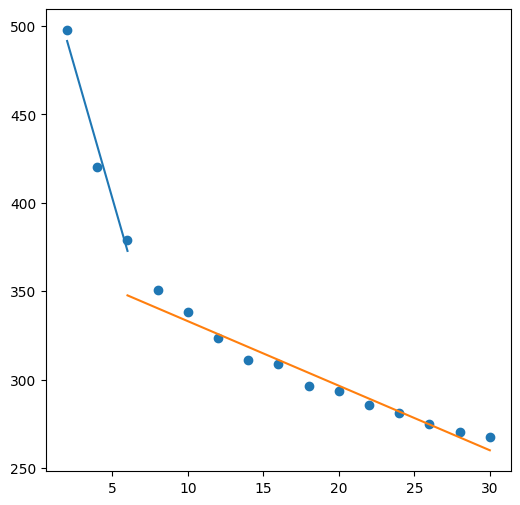

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###My Purity Score/No Breakpoint

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,252501,73896,216,798,108707,328,155885,14602,89191,16085,32191,0,27137,5657,124004
1,2,192545,2525,4319,65041,39873,39327,42169,141352,10972,29636,69024,1398,27127,56102,830


Purity Score: 0.7622834995854477
Purity Score: 0.7630091201511853
Purity Score: 0.5962894794873596
Purity Score: 0.5763010352104607
Purity Score: 0.5185242676344892
Purity Score: 0.45325167946050293
Purity Score: 0.42425519175970994
Purity Score: 0.36529451694490334
Purity Score: 0.35219577218224535
Purity Score: 0.34189787352519774
Purity Score: 0.2900603533981587
Purity Score: 0.29777546170534386
Purity Score: 0.26676473015908214
Purity Score: 0.260479303798482
Purity Score: 0.2561958017491275
['Zonal_mlra_2.csv', 'Zonal_mlra_4.csv', 'Zonal_mlra_6.csv', 'Zonal_mlra_8.csv', 'Zonal_mlra_10.csv', 'Zonal_mlra_12.csv', 'Zonal_mlra_14.csv', 'Zonal_mlra_16.csv', 'Zonal_mlra_18.csv', 'Zonal_mlra_20.csv', 'Zonal_mlra_22.csv', 'Zonal_mlra_24.csv', 'Zonal_mlra_26.csv', 'Zonal_mlra_28.csv', 'Zonal_mlra_30.csv']


,LABEL,MLRA__12,MLRA__14,MLRA__22,MLRA__24,MLRA__25,MLRA__26,MLRA__27,MLRA__28,MLRA__29,...,MLRA__50,MLRA__51,MLRA__52,MLRA__55,MLRA__84,MLRA__85,MLRA__93,MLRA__94,MLRA__95,MLRA__96
0,1,0,0,0,3011,21538,2939,4902,50735,71249,...,104,1741,1366,830,2722,42223,479,1443,5480,130
1,2,265,2329,1377,16513,18854,61249,10505,9407,74616,...,2373,72462,41115,1007,28556,14208,5338,7218,13025,953


Purity Score: 0.7896529336542987
Purity Score: 0.772632244203036
Purity Score: 0.6446801721780224
Purity Score: 0.5931388733525682
Purity Score: 0.5348711005546262
Purity Score: 0.4756639621149217
Purity Score: 0.4580747254588416
Purity Score: 0.41872608467472694
Purity Score: 0.3932437127179636
Purity Score: 0.37583926930288597
Purity Score: 0.33548535328771817
Purity Score: 0.3327454855011223
Purity Score: 0.32238043261329674
Purity Score: 0.3093204782941859
Purity Score: 0.3216209323927768
['Zonal_eco4_2.csv', 'Zonal_eco4_4.csv', 'Zonal_eco4_6.csv', 'Zonal_eco4_8.csv', 'Zonal_eco4_10.csv', 'Zonal_eco4_12.csv', 'Zonal_eco4_14.csv', 'Zonal_eco4_16.csv', 'Zonal_eco4_18.csv', 'Zonal_eco4_20.csv', 'Zonal_eco4_22.csv', 'Zonal_eco4_24.csv', 'Zonal_eco4_26.csv', 'Zonal_eco4_28.csv', 'Zonal_eco4_30.csv']


,LABEL,US_L4_13a,US_L4_13aa,US_L4_13ac,US_L4_13b,US_L4_13c,US_L4_13d,US_L4_13e,US_L4_13f,US_L4_13g,...,US_L4_80l,US_L4_81d,US_L4_81g,US_L4_81i,US_L4_81j,US_L4_81k,US_L4_81l,US_L4_81m,US_L4_81n,US_L4_81o
0,1,19271,4029,78,37471,17117,1948,0,0,1244,...,1100,1084,2659,9544,31905,32668,32926,1089,9399,2730
1,2,10330,4278,2,6629,22599,25639,4039,3537,1808,...,337,0,374,3,188,235,30,0,0,0


Purity Score: 0.8643446808563062
Purity Score: 0.8524778895159532
Purity Score: 0.7466986728165782
Purity Score: 0.7083818414993366
Purity Score: 0.6570432625083311
Purity Score: 0.6023463784881221
Purity Score: 0.6130348063800404
Purity Score: 0.5733776097393309
Purity Score: 0.5547960562707045
Purity Score: 0.5358750996342331
Purity Score: 0.5026265246963543
Purity Score: 0.49340350540026784
Purity Score: 0.481420294461507
Purity Score: 0.4815502655475602
Purity Score: 0.4844878584830465


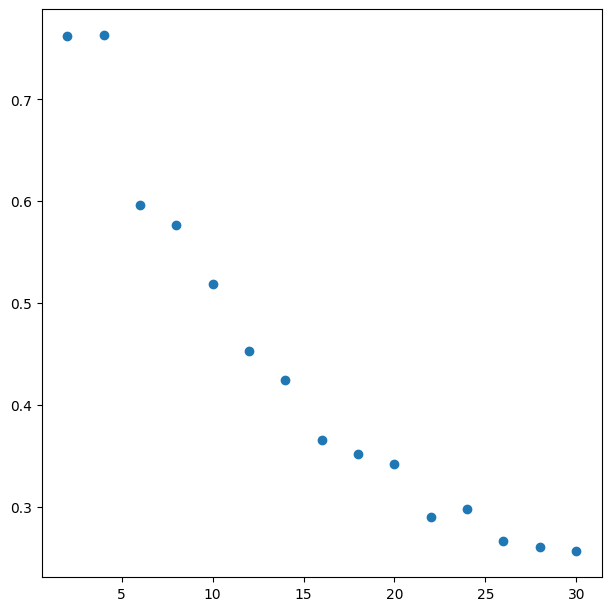

In [117]:
import os
import pandas as pd
import matplotlib.pyplot as plt

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

purity_eco3 = test_scores






fld = '/content/drive/My Drive/Colab Notebooks/Analogs/ZonalM_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


purity_mlra = test_scores









fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal4_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  max_values_per_col = df.max()
  score = max_values_per_col.sum()/n
  test_scores.append(score)
  print(f"Purity Score: {score.item()}")


purity_eco4 = test_scores






### Purity Score/No Breakpoint (Not Used)

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,252501,73896,216,798,108707,328,155885,14602,89191,16085,32191,0,27137,5657,124004
1,2,192545,2525,4319,65041,39873,39327,42169,141352,10972,29636,69024,1398,27127,56102,830


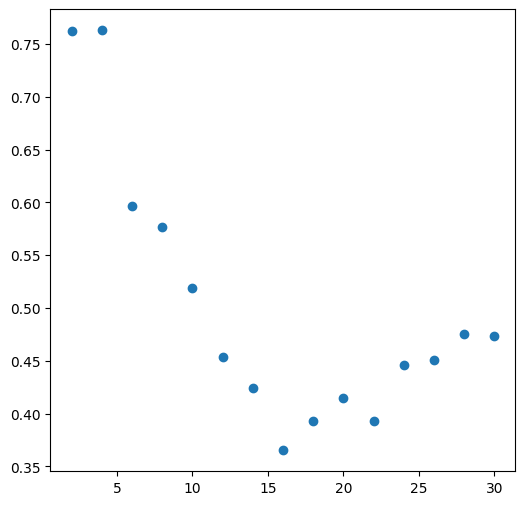

In [ ]:
import os
import permetrics
from permetrics import ClusteringMetric
import pandas as pd
import matplotlib.pyplot as plt


'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco3_{}.csv'.format(n)))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  arr = df.to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.purity_score())


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Purity Score/One Breakpoint

Optimal breakpoint 1: 12.222222222222221


/tmp/ipython-input-1430848010.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


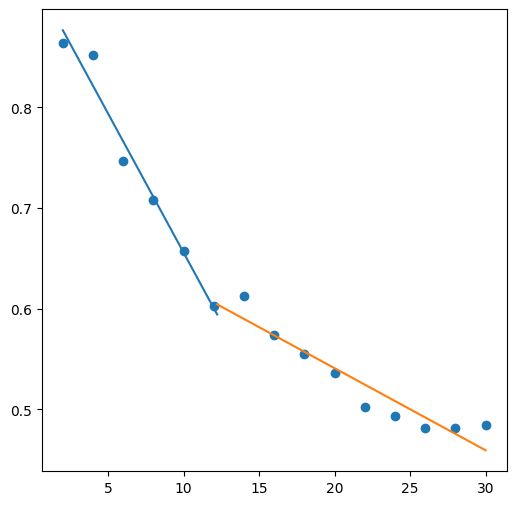

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###My Entropy Score/No Breakpoint

['Zonal_eco3_2.csv', 'Zonal_eco3_4.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_8.csv', 'Zonal_eco3_10.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_14.csv', 'Zonal_eco3_16.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_20.csv', 'Zonal_eco3_22.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_26.csv', 'Zonal_eco3_28.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,252501,73896,216,798,108707,328,155885,14602,89191,16085,32191,0,27137,5657,124004
1,2,192545,2525,4319,65041,39873,39327,42169,141352,10972,29636,69024,1398,27127,56102,830


['Zonal_mlra_2.csv', 'Zonal_mlra_4.csv', 'Zonal_mlra_6.csv', 'Zonal_mlra_8.csv', 'Zonal_mlra_10.csv', 'Zonal_mlra_12.csv', 'Zonal_mlra_14.csv', 'Zonal_mlra_16.csv', 'Zonal_mlra_18.csv', 'Zonal_mlra_20.csv', 'Zonal_mlra_22.csv', 'Zonal_mlra_24.csv', 'Zonal_mlra_26.csv', 'Zonal_mlra_28.csv', 'Zonal_mlra_30.csv']


/tmp/ipython-input-2103368715.py:40: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-2103368715.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


,LABEL,MLRA__12,MLRA__14,MLRA__22,MLRA__24,MLRA__25,MLRA__26,MLRA__27,MLRA__28,MLRA__29,...,MLRA__50,MLRA__51,MLRA__52,MLRA__55,MLRA__84,MLRA__85,MLRA__93,MLRA__94,MLRA__95,MLRA__96
0,1,0,0,0,3011,21538,2939,4902,50735,71249,...,104,1741,1366,830,2722,42223,479,1443,5480,130
1,2,265,2329,1377,16513,18854,61249,10505,9407,74616,...,2373,72462,41115,1007,28556,14208,5338,7218,13025,953


/tmp/ipython-input-2103368715.py:94: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-2103368715.py:94: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


['Zonal_eco4_2.csv', 'Zonal_eco4_4.csv', 'Zonal_eco4_6.csv', 'Zonal_eco4_8.csv', 'Zonal_eco4_10.csv', 'Zonal_eco4_12.csv', 'Zonal_eco4_14.csv', 'Zonal_eco4_16.csv', 'Zonal_eco4_18.csv', 'Zonal_eco4_20.csv', 'Zonal_eco4_22.csv', 'Zonal_eco4_24.csv', 'Zonal_eco4_26.csv', 'Zonal_eco4_28.csv', 'Zonal_eco4_30.csv']


,LABEL,US_L4_13a,US_L4_13aa,US_L4_13ac,US_L4_13b,US_L4_13c,US_L4_13d,US_L4_13e,US_L4_13f,US_L4_13g,...,US_L4_80l,US_L4_81d,US_L4_81g,US_L4_81i,US_L4_81j,US_L4_81k,US_L4_81l,US_L4_81m,US_L4_81n,US_L4_81o
0,1,19271,4029,78,37471,17117,1948,0,0,1244,...,1100,1084,2659,9544,31905,32668,32926,1089,9399,2730
1,2,10330,4278,2,6629,22599,25639,4039,3537,1808,...,337,0,374,3,188,235,30,0,0,0


/tmp/ipython-input-2103368715.py:150: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-2103368715.py:150: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


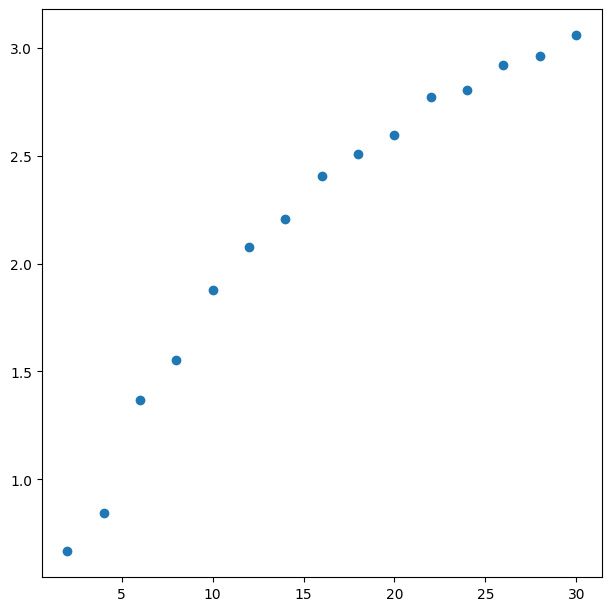

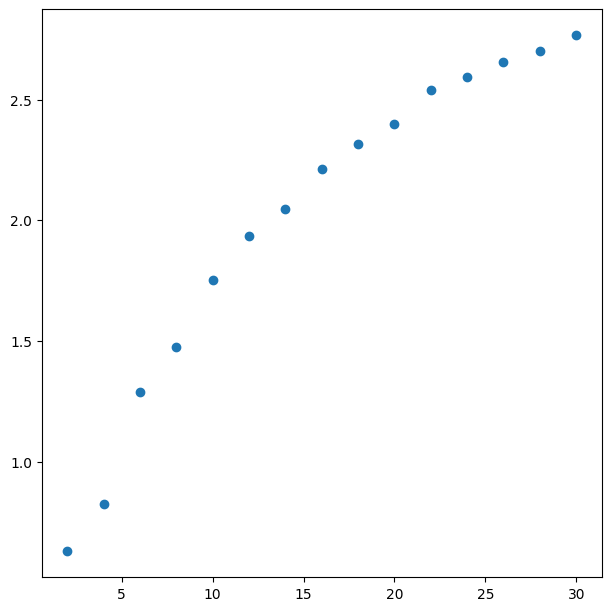

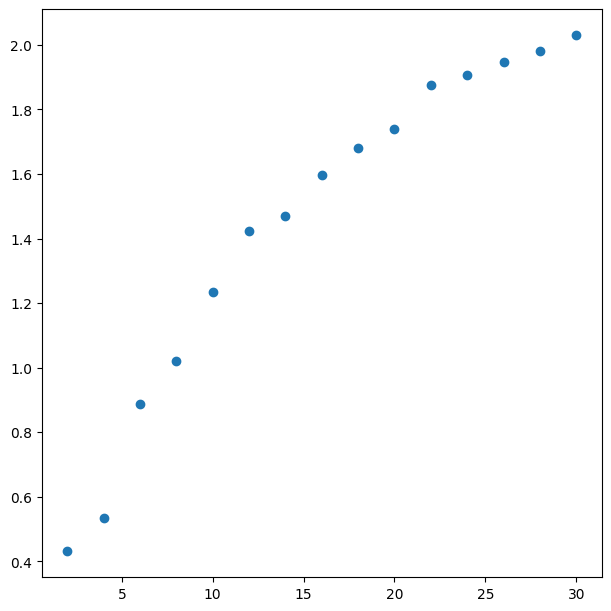

In [118]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal3_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(-entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

entropy_eco3 = test_scores








fld = '/content/drive/My Drive/Colab Notebooks/Analogs/ZonalM_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(-entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

entropy_mlra = test_scores










fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal4_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  n = df.sum().sum()
  sum_values_per_col = df.sum()
  entropy = 0
  for i, n_col in enumerate(sum_values_per_col):
    sr = df.iloc[:, i].divide(n_col)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (n_col/n)
    entropy += col_entropy

  test_scores.append(-entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)

entropy_eco4 = test_scores







### Entropy Score/No Breakpoint (Not Used)

['Zonal_eco4_2.csv', 'Zonal_eco4_4.csv', 'Zonal_eco4_6.csv', 'Zonal_eco4_8.csv', 'Zonal_eco4_10.csv', 'Zonal_eco4_12.csv', 'Zonal_eco4_14.csv', 'Zonal_eco4_16.csv', 'Zonal_eco4_18.csv', 'Zonal_eco4_20.csv', 'Zonal_eco4_22.csv', 'Zonal_eco4_24.csv', 'Zonal_eco4_26.csv', 'Zonal_eco4_28.csv', 'Zonal_eco4_30.csv']


,LABEL,US_L4_13a,US_L4_13aa,US_L4_13ac,US_L4_13b,US_L4_13c,US_L4_13d,US_L4_13e,US_L4_13f,US_L4_13g,...,US_L4_80l,US_L4_81d,US_L4_81g,US_L4_81i,US_L4_81j,US_L4_81k,US_L4_81l,US_L4_81m,US_L4_81n,US_L4_81o
0,1,19271,4029,78,37471,17117,1948,0,0,1244,...,1100,1084,2659,9544,31905,32668,32926,1089,9399,2730
1,2,10330,4278,2,6629,22599,25639,4039,3537,1808,...,337,0,374,3,188,235,30,0,0,0


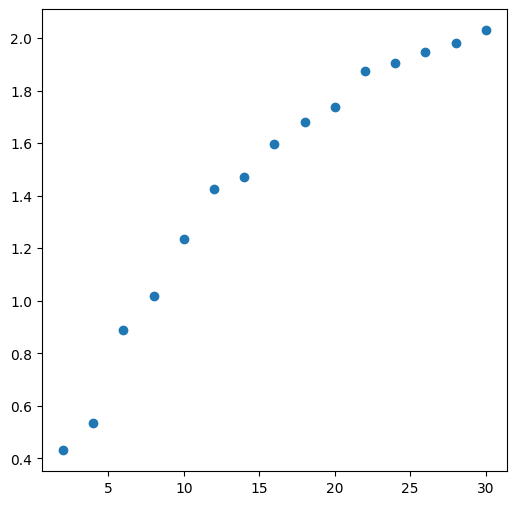

In [ ]:
from permetrics import ClusteringMetric

'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal4_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco4_{}.csv'.format(n)))
  mask = df.iloc[:, 1:].any(axis=1)
  df = df.iloc[:, 1:][mask]
  arr = df.to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.entropy_score())


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)



###Entropy Score/One Breakpoint

Optimal breakpoint 1: 12.222222222222221


/tmp/ipython-input-2898114523.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


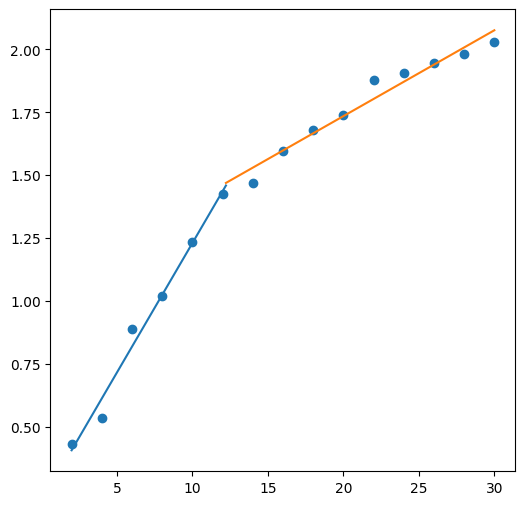

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



### Panel Figure

/tmp/ipython-input-1080555559.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


Optimal breakpoint 1: 6.000001116801738
Optimal breakpoint 1: 14.222222222222221
Optimal breakpoint 1: 8.222222222222221
Optimal breakpoint 1: 14.222222222222221
Optimal breakpoint 1: 12.222222222222221
Optimal breakpoint 1: 12.222222222222221
Optimal breakpoint 1: 10.222222222222221
Optimal breakpoint 1: 12.222222222222221
Optimal breakpoint 1: 12.222222222222221


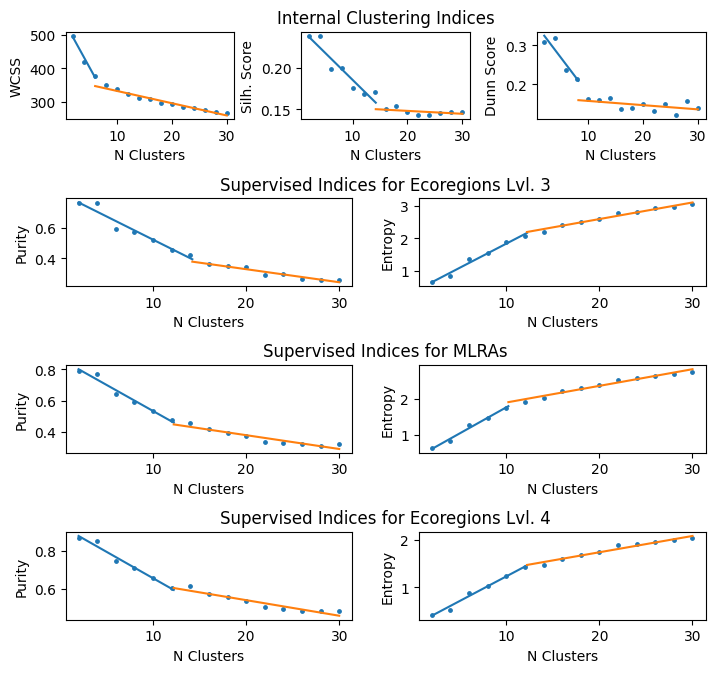

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params



fig = plt.figure(figsize=(8, 6))



ghost = fig.add_gridspec(4, 6)
ghost.update(left=0.1, right=0.9, top=0.99, bottom=0.01, wspace=1.3, hspace=0.9)
axg1 = fig.add_subplot(ghost[0,0:2])
axg2 = fig.add_subplot(ghost[0,2:4])
axg3 = fig.add_subplot(ghost[0,4:])
axg4 = fig.add_subplot(ghost[1,0:2])
axg5 = fig.add_subplot(ghost[1,2:4])
axg6 = fig.add_subplot(ghost[1,4:])
axg7 = fig.add_subplot(ghost[2,0:2])
axg8 = fig.add_subplot(ghost[2,2:4])
axg9 = fig.add_subplot(ghost[2,4:])
axg10 = fig.add_subplot(ghost[3,0:2])
axg11 = fig.add_subplot(ghost[3,2:4])
axg12 = fig.add_subplot(ghost[3,4:])
axg1.set_axis_off()
axg2.set_axis_off()
axg3.set_axis_off()
axg4.set_axis_off()
axg5.set_axis_off()
axg6.set_axis_off()
axg7.set_axis_off()
axg8.set_axis_off()
axg9.set_axis_off()
axg10.set_axis_off()
axg11.set_axis_off()
axg12.set_axis_off()



gs = fig.add_gridspec(4, 6)
gs.update(left=0.1, right=0.9, top=0.99, bottom=0.01, wspace=1.3, hspace=0.9)
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:])
ax4 = fig.add_subplot(gs[1,:3])
ax5 = fig.add_subplot(gs[1,3:])
ax6 = fig.add_subplot(gs[2,:3])
ax7 = fig.add_subplot(gs[2,3:])
ax8 = fig.add_subplot(gs[3,:3])
ax9 = fig.add_subplot(gs[3,3:])



axwut = fig.add_subplot(ghost[:])
axwut.axis('off')
axwut.set_title('Internal Clustering Indices')

#axg2.set_title('Internal Indices')
axg5.set_title('Supervised Indices for Ecoregions Lvl. 3')
axg8.set_title('Supervised Indices for MLRAs')
axg11.set_title('Supervised Indices for Ecoregions Lvl. 4')

ax1.set_ylabel('WCSS')
ax2.set_ylabel('Silh. Score')
ax3.set_ylabel('Dunn Score')
ax4.set_ylabel('Purity')
ax5.set_ylabel('Entropy')
ax6.set_ylabel('Purity')
ax7.set_ylabel('Entropy')
ax8.set_ylabel('Purity')
ax9.set_ylabel('Entropy')

ax1.set_xlabel('N Clusters')
ax2.set_xlabel('N Clusters')
ax3.set_xlabel('N Clusters')
ax4.set_xlabel('N Clusters')
ax5.set_xlabel('N Clusters')
ax6.set_xlabel('N Clusters')
ax7.set_xlabel('N Clusters')
ax8.set_xlabel('N Clusters')
ax9.set_xlabel('N Clusters')

scores = [wcss_scores, silhouette_scores, dunn_scores, purity_eco3, entropy_eco3, purity_mlra, entropy_mlra, purity_eco4, entropy_eco4]
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i, ax in enumerate(axes):

  x_data = np.array([float(x) for x in test_cluster_sizes])
  y_data = np.array([float(x) for x in scores[i]])

  optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
  b1, m1, c1, m2, c2 = optimal_params

  print('Optimal breakpoint 1:', optimal_b1)

  ax.scatter(x_data, y_data, s=6)
  ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
  ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



